In this notebook, I will build and evaluate regression models to predict delivery duration using the provided dataset. I will explore different regression techniques including Linear Regression, Polynomial Regression, Random Forest Regressor, and XGB Regressor. The performance of these models will be assessed using the Root Mean Squared Error (RMSE) as the evaluation metric.

# Delivery Duration Prediction (Stratascratch)

In [9]:
%pip install category_encoders

from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.


# Load Data

In [2]:
# Load data
df = pd.read_csv(data_path /'historical_data.csv')

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

# Data Preperation

In [5]:
# Convert timestamps
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [6]:
# Create target variable
df['total_delivery_duration_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [7]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [8]:
# Fill missing store_primary_category values with the mode grouped by store_id
df['store_primary_category'] = df.groupby('store_id')['store_primary_category'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))


# Check if any store_id has more than one store_primary_category
store_category_counts = df.groupby('store_id')['store_primary_category'].nunique()

# Filter store_ids with more than one unique store_primary_category
store_ids_with_multiple_categories = store_category_counts[store_category_counts > 1].index.tolist()

# For each store_id with multiple categories, replace the less frequent categories with the most frequent one
for store_id in store_ids_with_multiple_categories:
    most_frequent_category = df[df['store_id'] == store_id]['store_primary_category'].mode()[0]
    df.loc[df['store_id'] == store_id, 'store_primary_category'] = most_frequent_category

# Verify the changes
df[['store_id', 'store_primary_category']].drop_duplicates()

# # Ensure unique categories for each store_id
# duplicate_categories = df.groupby('store_primary_category')['store_id'].nunique()
# duplicate_categories = duplicate_categories[duplicate_categories > 1].index.tolist()

# for category in duplicate_categories:
#     store_ids = df[df['store_primary_category'] == category]['store_id'].unique()
#     for store_id in store_ids[1:]:
#         second_most_frequent_category = df[df['store_id'] == store_id]['store_primary_category'].value_counts()
#         df.loc[df['store_id'] == store_id, 'store_primary_category'] = second_most_frequent_category
        

KeyboardInterrupt: 

In [ ]:
df['store_primary_category'].isna().sum()

np.int64(0)

In [ ]:
# Fill missing values
# Get categorical features with missing values
categorical_features_with_na = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().any()].tolist()

# Get numeric features with missing values
numeric_features_with_na = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()].tolist()

In [ ]:
# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
df[numeric_features_with_na] = imputer.fit_transform(df[numeric_features_with_na])


# For categorical features, fill missing values with mode
for col in categorical_features_with_na:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# Drop rows with missing actual_delivery_time
df = df.dropna(subset=['actual_delivery_time'])

# Verify the changes
df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_duration_seconds                 0
dtype: int64

In [ ]:
# Feature Engineering
# Extracting more date and time features
df['created_at_weekday'] = df['created_at'].dt.weekday
df['created_at_weekofyear'] = df['created_at'].dt.isocalendar().week


# Calculate the average item price
df['avg_item_price'] = df['subtotal'] / df['total_items']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197421 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   store_primary_category                        197421 non-null  object        
 5   order_protocol                                197421 non-null  float64       
 6   total_items                                   197421 non-null  int64         
 7   subtotal                                      197421 non-null  int64         
 8   num_distinct_items                            197421 non-nu

In [ ]:
# Initialize the target encoder
target_encoder = TargetEncoder()

# Apply target encoding to the 'store_primary_category' column
df['store_primary_category'] = target_encoder.fit_transform(df['store_primary_category'], df['total_delivery_duration_seconds'])

# Display the first few rows of the dataframe with the encoded column
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,created_at_weekday,created_at_weekofyear,avg_item_price,store_primary_category_encoded
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,33.0,14.0,21.0,446,861.0,3779.0,4,6,860.25,2870.715556
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,indian,2.0,1,1900,1,1400,...,1.0,2.0,2.0,446,690.0,4024.0,1,7,1900.00,2989.596156
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,indian,1.0,1,1900,1,1900,...,1.0,0.0,0.0,446,690.0,1781.0,3,4,1900.00,2989.596156
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,indian,1.0,6,6900,5,600,...,1.0,1.0,2.0,446,289.0,3075.0,1,6,1150.00,2989.596156
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,indian,1.0,3,3900,3,1100,...,6.0,6.0,9.0,446,650.0,2390.0,6,7,1300.00,2989.596156


# Build Regression Models

### Full model

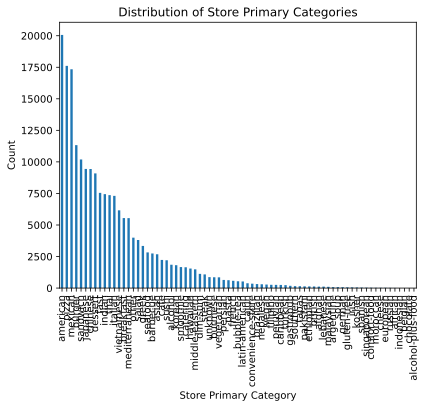

In [ ]:
# Check for imbalanced data
df['store_primary_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Store Primary Categories')
plt.xlabel('Store Primary Category')
plt.ylabel('Count')
plt.show()


In [ ]:
# Split the data into features and target variable
X = df.drop(columns=['total_delivery_duration_seconds'])
y = df['total_delivery_duration_seconds']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

### Linear Regression

### Polynomial Regression

### Random Forest Regressor

### XGB Regressor

create a README
write out what the business problem is.
pick a metric : RMSE
figure out the target column
basic eda including summary stats
at last 5 plots
clean the data - get rid of nulls, address errors or conflicts in the data
univariate analysis
multivariate analysis
check for multicollinearity

Run these models:
1. linear regression
2. polynomial regression
3. random forest regressor

Feature importance

metric anlysis for each model
pick the best model
summary of your results in plots and prose
"future directions"

1. what would you do to the modeling if you had more time
2. What else could doordash analyze to improve based on your experience with this data
3. minimum 30 commits to complete